In [1]:
# Start off importing necessary packages
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
import pandas
import scipy.stats
# Let's try to look at Benoit's dip-dpr interactions and try to pull out some predictors
# of cognate vs. non-cognate matches.

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-4:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)
import aims_loader as aimsLoad
import aims_analysis as aims
import aims_classification as classy

In [2]:
# You can edit these at some point if you want to change the formatting of your figures
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

# Custom colormap code from: https://stackoverflow.com/questions/49367144/modify-matplotlib-colormap
import matplotlib as mpl
upper = mpl.cm.jet(np.arange(256))
lower = np.ones((int(256/4),4))
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

cmap = np.vstack(( lower, upper ))
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

# DO NOT change the order of this key. All subsequent analysis is based on this
AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

# Alright so a slight difference from how we do MHC or Immunoglobulin Analysis
Here, we can now just read in a full multi-sequence alignment, treating the dashes as the padded zeros we've been using. If I remember correctly, the inspiration for using this padding for antibody analysis was from an MSA. Technically this doesn't need to be an Automated IMMUNE Molecule Separator anymore with this module. Can analyze any MSA! You just need to be aware of what assumptions the AIMS analysis makes. Read the documentation for more detail here

In [3]:
# Define the names of the subgroups you are analyzing
label = ['Interacting','Noninteracting']

# So this is a VERY specific example of looking at pairwise interactions between two molecules, each loaded in as an MSA
# You don't need to do this to load in any given MSA, just try to make sure there is similar formatting
cognate_pairs = aims.create_msa_pairs(file1 = 'app/MSA_testData/Dpr_interface.csv', file2 = 'app/MSA_testData/DIP_interface.csv', 
                                   pair_list = 'app/MSA_testData/cognate_list.txt', names = ['Dpr','DIP'], label = label[0])
noncognate_pairs = aims.create_msa_pairs(file1 = 'app/MSA_testData/Dpr_interface.csv', file2 = 'app/MSA_testData/DIP_interface.csv', 
                                   pair_list = 'app/MSA_testData/noncognate_list.txt', names = ['Dpr','DIP'], label = label[1])
# Load in the files you want to analyze. Place the path to your directory in single quotes
# Ideally there won't be spaces in file or folder names. Check example files for proper formatting of csv or txt files
seq1 = cognate_pairs
seq2 = noncognate_pairs

# If running on a mac, set parallel process to True for a speedup
# parallel processing has not yet been tested on other operating systems
parallel_process = False
# At one point we will break down our dataset into N top properties which best split these two subgroups
# Define that N here as "finalSize". Shouldn't make too large
# In classification applications must be particularly worried about overfitting with large N
finalSize = 10

In [4]:
# Change the way that we define mat_size. Unlike with the antibodies and TCRS, we don't have any variation here
# So keep it simple as possible, but also make SURE that these lengths are the same for seq1 and seq2
mat_size = [len(seq1.values[0][0]),len(seq1.values[1][0])]
AA_num_key = aims.get_props()[1]

In [5]:
for i in np.arange(len(mat_size)):
    if i == 0:
        xtick_loc = [mat_size[i]/2]
    else:
        pre_loc = sum(mat_size[:i])
        xtick_loc = xtick_loc + [mat_size[i]/2 + pre_loc]

In [6]:
# Again, VERY specific here. Can delete this line in other applications.
# Eventually, will use a script like this to incorporate metadata into the analysis more generally
meta_dist,dpr_pdb_numbering,dpr_aln_numbering,dip_pdb_numbering,dip_aln_numbering = aims.load_metadata('app/MSA_testData/AIMS_dist_input.txt')

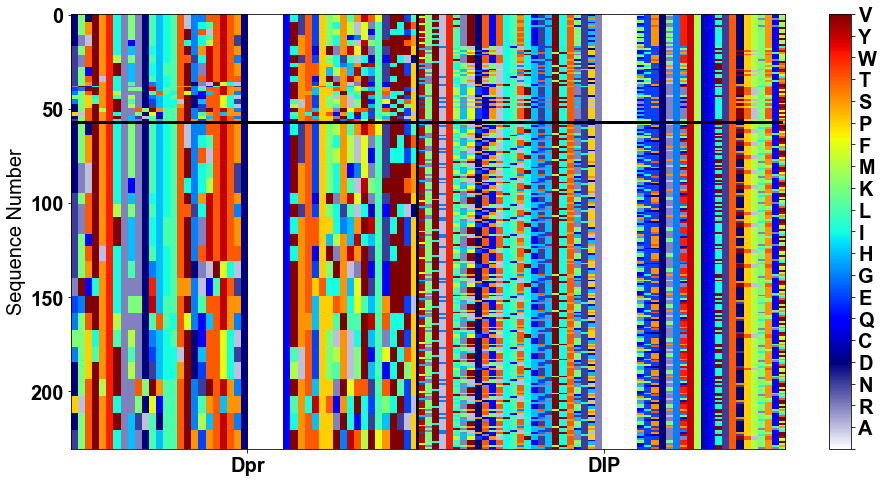

In [7]:
# Here we are getting the data into an AIMS-readable format... A numpy matrix
AA_num_key_dash = np.hstack((AA_num_key,[0]))
align = 'center'
seq_MI1 = aims.gen_MSA_matrix(np.array(seq1),key = AA_num_key_dash, giveSize = mat_size)
seq_MI2 = aims.gen_MSA_matrix(np.array(seq2),key = AA_num_key_dash, giveSize = mat_size)
seq_MIp1 = pandas.DataFrame(np.transpose(seq_MI1),columns = seq1.columns)
seq_MIp2 = pandas.DataFrame(np.transpose(seq_MI2),columns = seq2.columns)
seq_MIf = pandas.concat([seq_MIp1,seq_MIp2],axis=1)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
xyz = ax[0,0].imshow(np.transpose(seq_MIf), interpolation='nearest', aspect='auto',cmap=cmap)
ax[0,0].set_ylabel('Sequence Number')

# Plot a single line delineating the distinct groups we are studying.
ax[0,0].plot(np.arange(len(seq_MIf)),np.ones(len(seq_MIf))*len(seq_MI1),'black',linewidth = 3)
######
# It will help to have vertical lines to guide the viewer
seq1_len = np.shape(seq1)[1]; seq2_len = np.shape(seq2)[1]
Numclones = int(seq1_len + seq2_len)
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(Numclones),np.arange(Numclones),'black',linewidth = 3)
#######

ax[0,0].set_xticks(xtick_loc)
ax[0,0].set_xticklabels(['Dpr','DIP'])
color = pl.colorbar(xyz)
color.set_ticks(np.arange(21))
color.set_ticklabels([' '] + AA_key)
# Can also edit the saved figure name and format, if you want
#pl.savefig('MSA_mat.pdf',format='pdf')

# Calculate Position-Sensitive Biophysical Properties for the above matrix
No matter the sequence input format, once the data is into this AIMS matrix the analysis becomes similar for all molecules

In [8]:
# Process this new matrix and apply biophysical propery "masks"
dsetF = np.hstack((seq1.values,seq2.values))
#################### PARALLEL PROCESSING TO CREATE BIG MATRIX #######################
if parallel_process:
    import multiprocessing as mp
    def boot_it(data):
        bigass = classy.get_bigass_matrix(dsetF[:,data[0]:data[1]], giveSize = mat_size, alignment = align, norm=True,special='MSA')
        return(bigass)
    def do_boot(data):
        with mp.Pool() as pool:
            results = pool.map(boot_it, data)
            return(results)
    if __name__ == "__main__":
        # Probably a smarter way to calculate #seqs per node, but do 100 for now
        final = aims.gen_splits(splitMat = seq_MIf, splitSize = 100)
        big_pre = do_boot(final)
    # Still need to input seq1/seq2 for 
    full_big, weights, acc_all, mda_all, parsed_mat, top_names = aims.compile_MP(big_pre, seq1.values, seq2.values, final_size = finalSize)
else:

    full_big, weights, acc_all, mda_all, parsed_mat, top_names= classy.do_linear_split(seq1.values, seq2.values, special='MSA',
                                                                           giveSize = mat_size, ridCorr = True, matSize = finalSize)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# Visualize the Linear Discriminant Analysis

<AxesSubplot:xlabel='Dataset', ylabel='Linear Discriminant 1'>

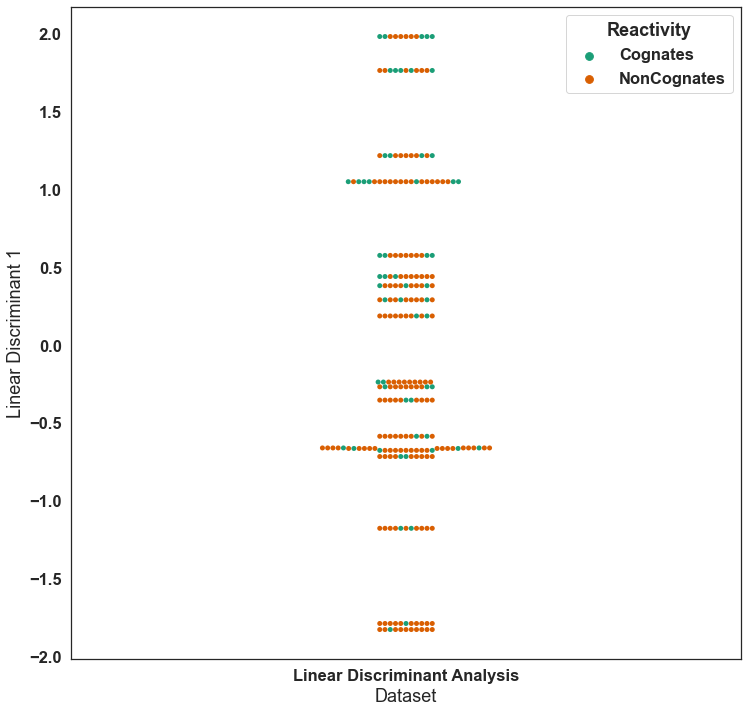

In [9]:
import seaborn as sns
fig = pl.figure(figsize = (12, 12))
dset = ["Linear Discriminant Analysis" for x in range(seq1_len+seq2_len)]
reacts = ["Cognates" for x in range(seq1_len)] + ["NonCognates" for x in range(seq2_len)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
    'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")
#pl.savefig('lda_plot.pdf',format='pdf')

In [10]:
# One last little bit of reformatting here
seq1_bigF, seq2_bigF = aims.split_reshape(full_big, matShape = len(seq_MIf), total_props = 61)
# Which property will you want to look at down the line? 1 = charge, 2 = hydrophobicity... see full list in eLife paper (Boughter et al. 2020)

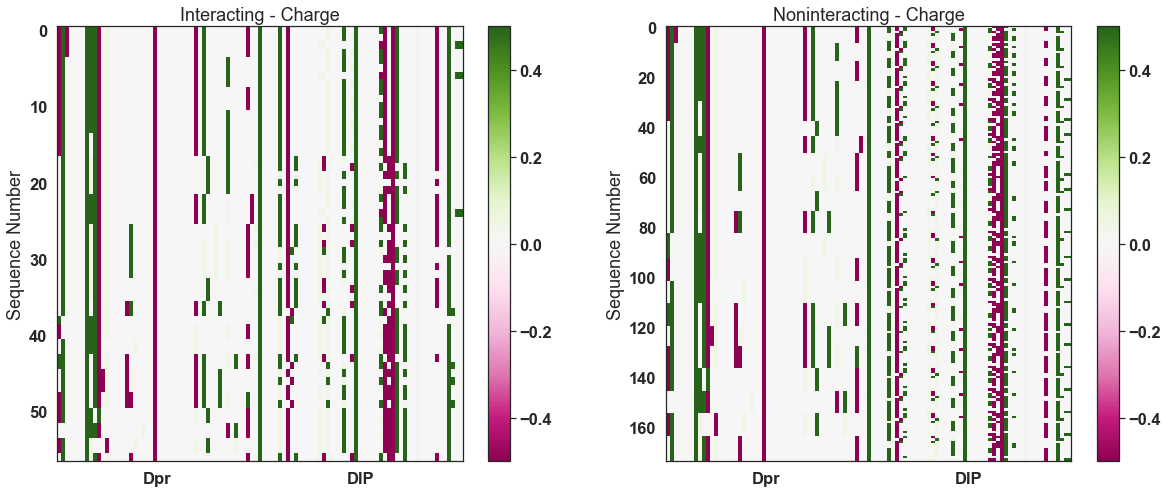

In [11]:
# Generate the position sensitive charge across all clones in the dataset
prop1 = 1
fig, axs = pl.subplots(1, 2,squeeze=False,figsize=(20,8))
ax1 = axs[0, 0]; ax2 = axs[0, 1]
x = ax1.imshow(seq1_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG,vmax=0.5,vmin=-0.5)
y = ax2.imshow(seq2_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG,vmax=0.5,vmin=-0.5)

ax1.set_xticks(xtick_loc); ax1.set_xticklabels(['Dpr','DIP'])
ax2.set_xticks(xtick_loc); ax2.set_xticklabels(['Dpr','DIP'])

ax1.set_ylabel('Sequence Number'); ax2.set_ylabel('Sequence Number')
ax1.set_title(label[0] + ' - Charge'); ax2.set_title(label[1] + ' - Charge')
fig.colorbar(x, ax=axs[0,0]); fig.colorbar(y, ax=axs[0,1])
#pl.savefig('MSA_chargeMat.pdf',format='pdf')

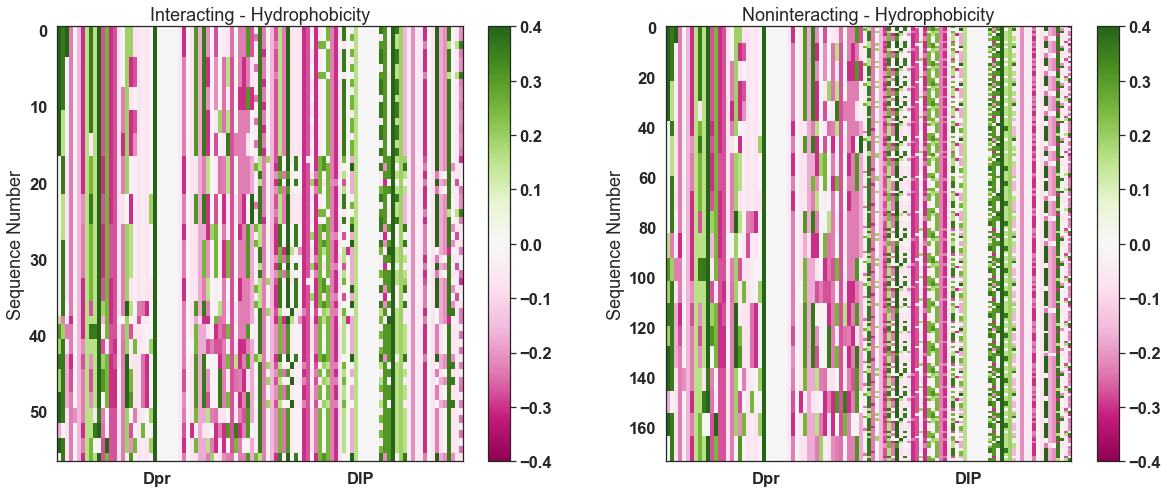

In [12]:
# Generate the position sensitive charge across all clones in the dataset
prop1 = 2
fig, axs = pl.subplots(1, 2,squeeze=False,figsize=(20,8))
ax1 = axs[0, 0]; ax2 = axs[0, 1]
x = ax1.imshow(seq1_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG,vmax=0.4,vmin=-0.4)
y = ax2.imshow(seq2_bigF[:,prop1,:],interpolation='nearest', aspect='auto',cmap=cm.PiYG,vmax=0.4,vmin=-0.4)

ax1.set_xticks(xtick_loc); ax1.set_xticklabels(['Dpr','DIP'])
ax2.set_xticks(xtick_loc); ax2.set_xticklabels(['Dpr','DIP'])

ax1.set_ylabel('Sequence Number'); ax2.set_ylabel('Sequence Number')
ax1.set_title(label[0] + ' - Hydrophobicity'); ax2.set_title(label[1] + ' - Hydrophobicity')
fig.colorbar(x, ax=axs[0,0]); fig.colorbar(y, ax=axs[0,1])
#pl.savefig('MSA_phobMat.pdf',format='pdf')

Text(0, 0.5, 'Normalized Property Value')

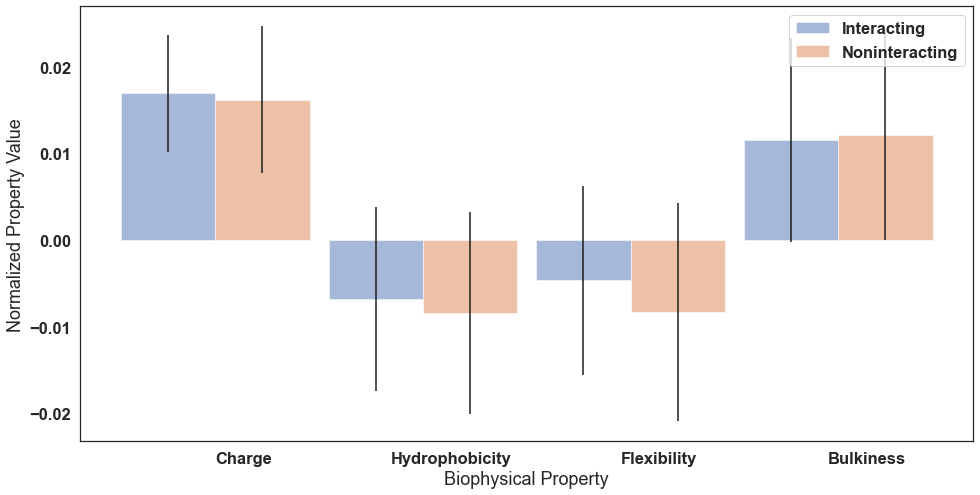

In [13]:
# Look at biophysical properties averaged over clones AND position
# Note for old users of the software, you might get different looking results because
# originally I normalized vectors to unit length, but NOT 0 mean. I now do both.
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# Need to have some kind of color wheel to replace this...
# We want to exclude prop0 (the simple 1-21 AA representation entries)
for prop in np.arange(4):
    propF = prop+1
    plotProp1 = np.average(np.average(seq1_bigF[:,propF,:],axis = 1))
    plotProp2 = np.average(np.average(seq2_bigF[:,propF,:],axis = 1))
    plotstd1 = np.std(np.average(seq1_bigF[:,propF,:],axis = 1))
    plotstd2 = np.std(np.average(seq2_bigF[:,propF,:],axis = 1))
    if prop == 0:
        plot1 = plotProp1; std1 = plotstd1
        plot2 = plotProp2; std2 = plotstd2
    else:
        plot1 = np.hstack((plot1,plotProp1)); std1 = np.hstack((std1,plotstd1))
        plot2 = np.hstack((plot2,plotProp2)); std2 = np.hstack((std2,plotstd2))
        
ax[0,0].bar(x_axis, plot1,
            yerr = std1,alpha = 0.5, width = 1/len(label))
ax[0,0].bar(x_axis+1/len(label), plot2,
            yerr = std2,alpha = 0.5, width = 1/len(label))
        
ax[0,0].legend(label)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Flexibility','Bulkiness'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
#pl.savefig('MSA_netProp.pdf',format='pdf')

Text(0, 0.5, 'Normalized Hydrophobicity')

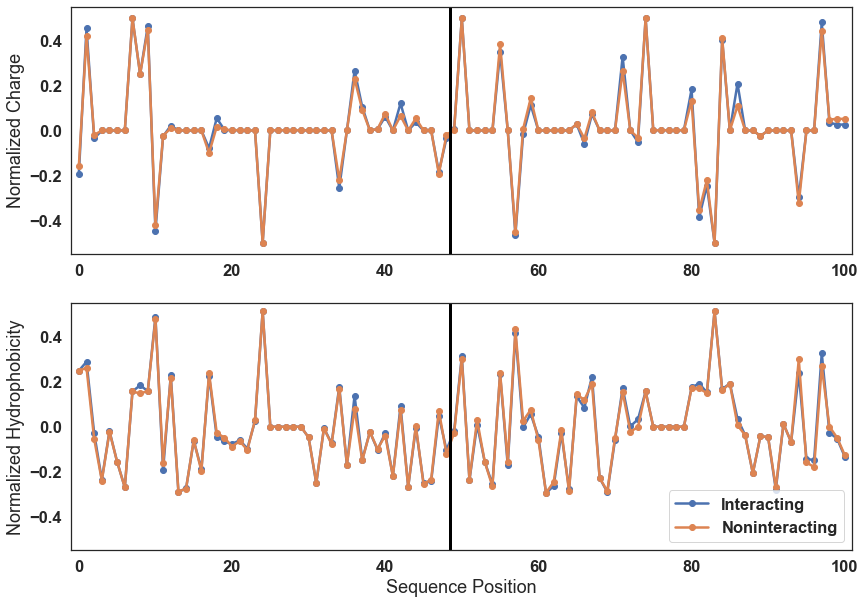

In [14]:
# Now get the position sensitive avarege biophysical properties
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(14,10))
prop1 = 1
plotProp11 = np.average(seq1_bigF[:,prop1,:],axis = 0); plotProp21 = np.average(seq2_bigF[:,prop1,:],axis = 0)
ax[0,0].set_ylabel('Charge')
# Set some custom axis limits just for the paper
ax[0,0].set_ylim([-0.55,0.55]); ax[0,0].set_xlim([-1,len(seq_MIf)])
ax[0,0].plot(plotProp11,marker='o',linewidth=2.5); ax[0,0].plot(plotProp21,marker='o',linewidth=2.5)

prop2 = 2
plotProp12 = np.average(seq1_bigF[:,prop2,:],axis = 0); plotProp22 = np.average(seq2_bigF[:,prop2,:],axis = 0)
ax[1,0].set_ylabel('Hydrophobicity'); ax[1,0].plot(plotProp12,marker='o',linewidth=2.5)
ax[1,0].set_ylim([-0.55,0.55]); ax[1,0].set_xlim([-1,len(seq_MIf)])
ax[1,0].plot(plotProp22,marker='o',linewidth=2.5); ax[1,0].set_xlabel('Sequence Position')
pl.legend(label)

# Draw some nice lines to guide 
y11, y12 = ax[0,0].get_ylim();y21, y22 = ax[1,0].get_ylim()
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y11,y12,100),'black',linewidth = 3)
        ax[1,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(y21,y22,100),'black',linewidth = 3)

ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydrophobicity')
#pl.savefig('MSA_posProp.pdf',format='pdf')

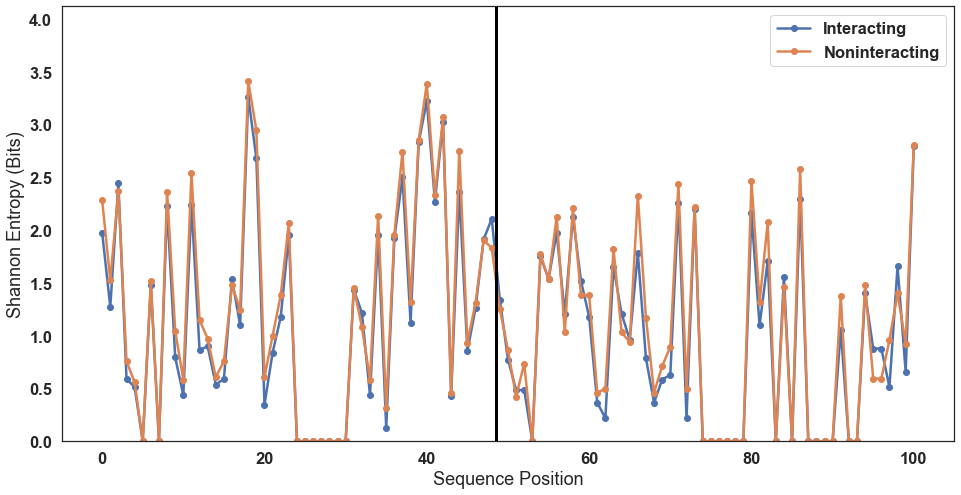

In [15]:
# Calculate the Shannon Entropy, a proxy for diversity
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
poses = len(seq_MIf)
frequencies = np.zeros((len(label),poses,21))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    entropy,AA_count=aims.calculate_shannon(np.transpose(subset))
    frequencies[i] = AA_count
    pl.plot(entropy,marker='o',linewidth=2.5)

pl.legend(label); pl.xlabel('Sequence Position'); pl.ylabel('Shannon Entropy (Bits)')
# Entropy is a rare case where we know the exact bounds of the values...
# Comment this out if your max entropy is substantially lower
pl.ylim([0,4.12])
# Guide the eyes with these lines
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,4.2,100),'black',linewidth = 3)

#pl.savefig('MSA_shannon.pdf',format='pdf')

Text(0.5, 1.0, 'Noninteracting')

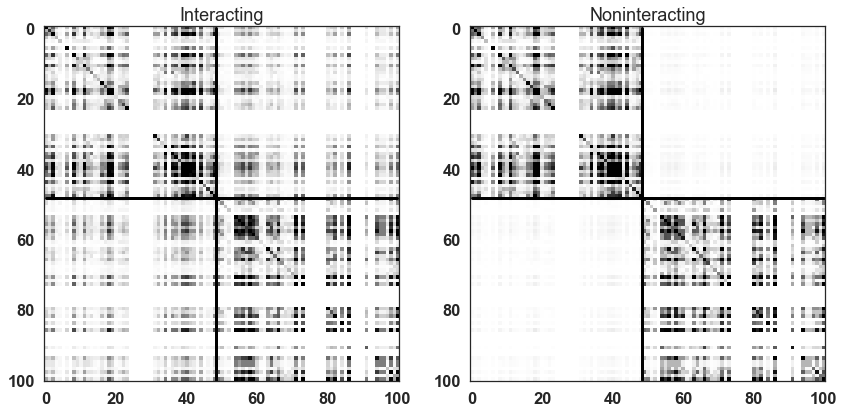

In [16]:
# And then the mutual information:
# NOTE FOR FUTURE: Probably could stand to parallelize this...
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(14,10))
MI_master = np.zeros((len(label),poses,poses))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    MI,entropy_cond,counted=aims.calculate_MI(np.transpose(subset))
    MI_master[i] = MI
    if i > 3:
        continue
    # NOTE, CHANGE VMAX HERE IF SIGNAL IS BLOWN OUT/TOO DIM
    ax[0,i].imshow(MI,vmin=0,vmax=1.5,cmap=cm.Greys)

# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses-1,100),'black',linewidth = 3)
        ax[0,0].plot( np.linspace(0,poses-1,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)
        ax[0,1].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses-1,100),'black',linewidth = 3)
        ax[0,1].plot( np.linspace(0,poses-1,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

ax[0,0].set_title(label[0])
ax[0,1].set_title(label[1])
#pl.savefig('MSA_MI.pdf',format='pdf')

Text(0, 0.5, 'Sequence Position')

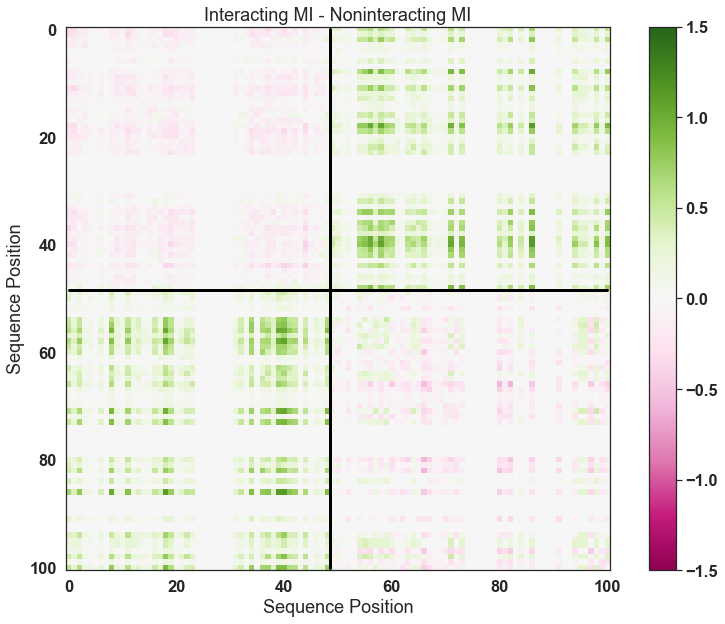

In [17]:
# A bit easier to look at the DIFFERENCE in mutual information:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
x = pl.imshow(MI_master[0] - MI_master[1], cmap=cm.PiYG, vmin = -1.5, vmax = 1.5)
pl.colorbar(x); pl.title(label[0]+ ' MI - ' + label[1] + ' MI')

# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.linspace(0,poses-1,100),'black',linewidth = 3)
        ax[0,0].plot( np.linspace(0,poses-1,100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

pl.xlabel('Sequence Position'); pl.ylabel('Sequence Position')
#pl.savefig('MSA_MIdiff.pdf',format='pdf')

# Alright Now we need to somehow encode "rules" for how to score interactions
See Dpr-DIP Manuscript (Submitted for Review) for more details as to the specifics here.

This is vague for the time being, but when the time allows I will write up a more comprehensive documentation. The basic idea is that we are using a "caveman scoring" to get a very rough idea of how residues interact.

For every step up to this point, you could do the analysis for either single molecular species OR a comparison. In the next steps, you need to be doing a pairwise interaction. So careful in venturing past this point

In [18]:
cognate_scores, cognate_average, cognate_std = aims.get_interaction_score(seq1)
noncognate_scores, noncognate_average, noncognate_std = aims.get_interaction_score(seq2)

Text(0.5, 0, 'Molecule 2 Sequence Position')

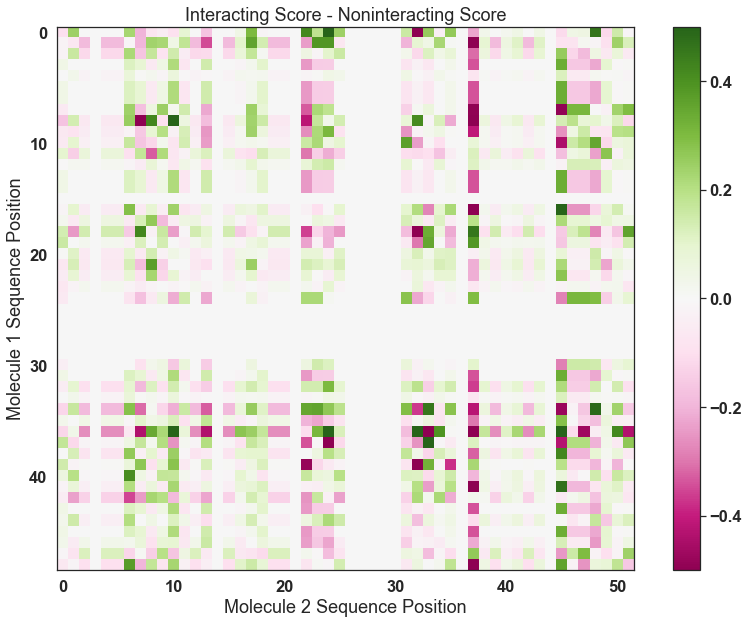

In [19]:
# These steps are very specifically for Dpr-DIP analysis example. Important for converting between MSA numbering
# and comparison to a specific PDB numbering. Can leave this step out if doing other analysis
dist_df = pandas.DataFrame(np.zeros([len(dpr_pdb_numbering),len(dip_pdb_numbering)]))
dist_df.index = dpr_pdb_numbering
dist_df.columns = dip_pdb_numbering

# Here, we are interested in incorporating pairwise distances from a PDB. Not necessary for all analysis
for i in meta_dist.values:
    dist_df.loc[int(i[0]),int(i[1])] = 1/i[2]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
# A bit easier to look at the DIFFERENCE in interaction score:
score_diff = np.transpose(cognate_average - noncognate_average)

x = pl.imshow(np.transpose(score_diff), cmap=cm.PiYG, vmin = -0.5, vmax = 0.5)
# Uncomment this if you want to view the pairwise distances
#x = pl.imshow(np.transpose(dist_df), cmap=cm.PiYG, vmin = -0.5, vmax = 0.5)
pl.colorbar(x); pl.title(label[0]+ ' Score - ' + label[1] + ' Score')

# Molecule 1 is DIP, Molecule 2 is Dpr for the included example
pl.ylabel('Molecule 1 Sequence Position'); pl.xlabel('Molecule 2 Sequence Position')
#pl.savefig('MSA_Scorediff',format='pdf')

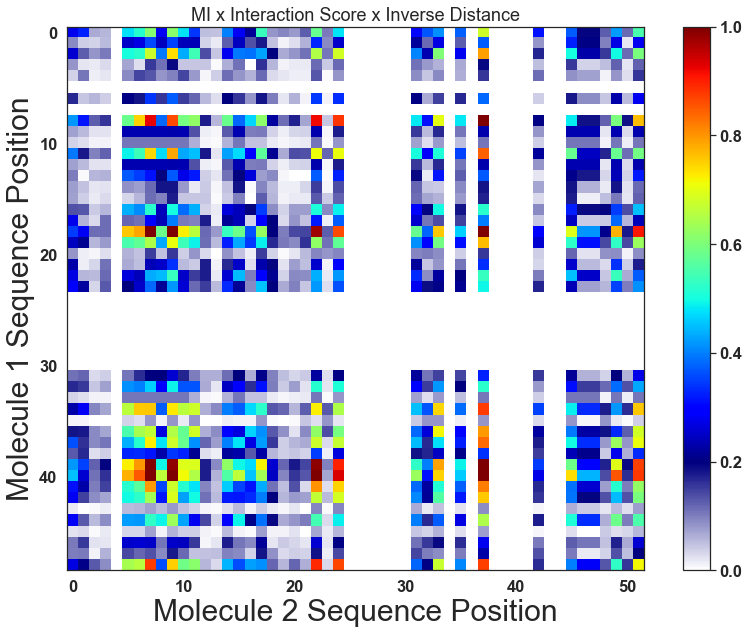

In [20]:
#Specifically pick out the Molecule1 - Molecule2 MI
dim1 = int(mat_size[0])
MI_diff = MI_master[0][dim1:,:dim1]- MI_master[1][dim1:,:dim1]

MI_df_Notscaled = pandas.DataFrame(MI_diff[:,:])
MI_df = pandas.DataFrame(MI_diff[:,:]* np.transpose(dist_df.values))

# And weight the score by the MI, as Benoit Roux suggested
score_df = pandas.DataFrame(score_diff * np.transpose(dist_df.values))
benoit_metric = score_df*MI_diff[:,:]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
# Visualize the MI
x = pl.imshow(np.transpose(MI_df_Notscaled), cmap=cmap, vmin = 0, vmax = 1.0)
pl.title('Mutual Information',fontsize=30)
# Or visualize MIxscorexdistance
#x = pl.imshow(np.transpose(benoit_metric), cmap=cm.PiYG, vmin = -0.01, vmax = 0.01)
pl.title('MI x Interaction Score x Inverse Distance')

pl.ylabel('Molecule 1 Sequence Position',fontsize=30); pl.xlabel('Molecule 2 Sequence Position',fontsize=30)
pl.colorbar(x)
#pl.savefig('MSA_MI.pdf',format='pdf')

In [21]:
# In this step, we identify the residue pairs with nonzero (dist scaled) MI, 
# nonzero (dist scaled) interaction score, or nonzero distxMIxScore
MI_pairs = np.transpose(np.transpose(MI_df).to_numpy().nonzero())
Interact_pairs = np.transpose(np.transpose(score_df).to_numpy().nonzero())
Benoit_pairs = np.transpose(np.transpose(benoit_metric).to_numpy().nonzero())

# Finalize which pair you'd like to pick for downstream analysis
pairs = Interact_pairs

# Lastly, select these pairs from our matrix of interaction scores
mols = ['Dpr','DIP']
cog_res_df = aims.generate_score_df(seq=seq1,scores=cognate_scores,dist=dist_df,pairs=pairs,mols=mols)
noncog_res_df = aims.generate_score_df(seq=seq2,scores=noncognate_scores,dist=dist_df,pairs=pairs,mols=mols)

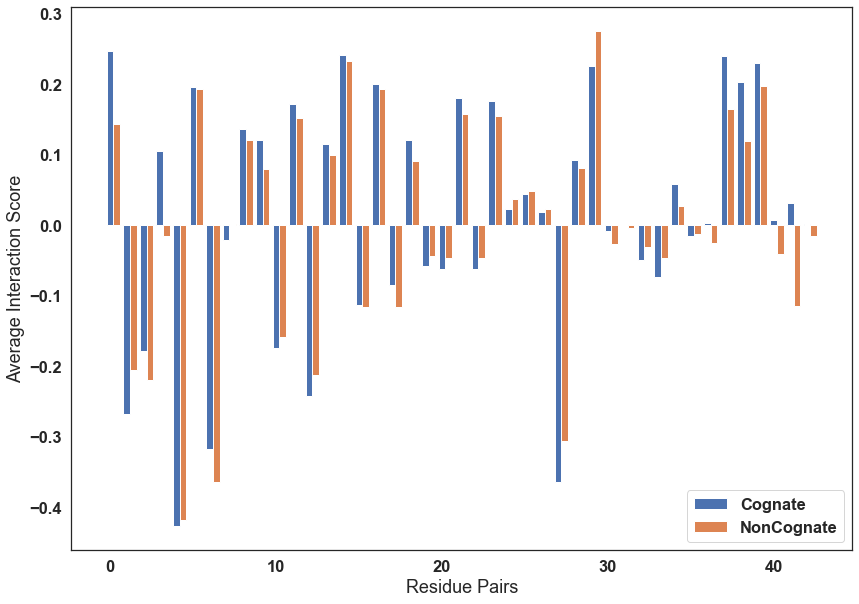

In [22]:
# In this step we re-shape the above dataframes and plot average scores across 
# all possible molecules in the dataset
first = True
for dub in pairs:
    pair_pre = cog_res_df[cog_res_df['Res1'] == str(int(dub[0]))]
    pair_F = pair_pre[pair_pre['Res2'] == str(int(dub[1]))]
    score_f = [float(a) for a in pair_F['Pair_Score'].values]
    plotIT_cog = np.average(score_f)
    ploterr_cog = np.std(score_f)
    
    pair_pre = noncog_res_df[noncog_res_df['Res1'] == str(int(dub[0]))]
    pair_F = pair_pre[pair_pre['Res2'] == str(int(dub[1]))]
    score_f = [float(a) for a in pair_F['Pair_Score'].values]
    plotIT_noncog = np.average(score_f)
    ploterr_noncog = np.std(score_f)
    
    if first:
        first = False
        final_scores = [plotIT_cog,plotIT_noncog]
        final_std = [ploterr_cog,ploterr_noncog]
    else:
        final_scores = np.vstack((final_scores,[plotIT_cog,plotIT_noncog]))
        final_std = np.vstack((final_std,[ploterr_cog,ploterr_noncog]))
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
pl.bar(np.arange(len(pairs)),final_scores[:,0],width = 0.4)
pl.bar(np.arange(len(pairs))+0.4,final_scores[:,1],width = 0.4)
pl.xlabel('Residue Pairs'); pl.ylabel('Average Interaction Score')
pl.legend(['Cognate','NonCognate'])
#pl.savefig('avg_interface_interaction_scores.pdf',format='pdf')

In [23]:
# So this module picks out the top 5 features with largest average differences in the plot above
# In other words, it is the maxdiff algorithm I already use but for these average features.
cog_TOP = aims.msa_maxdiff(frame = cog_res_df, pairs=pairs,scores = final_scores, top_X = 25)
noncog_TOP = aims.msa_maxdiff(frame = noncog_res_df, pairs=pairs,scores = final_scores, top_X = 25)

# So at this stage, we need to see if we can generalize
In other words, can we create a classifier that doesn't act on the residues of Dpr-DIP and instead acts on generalized values that will exist for all proteins

In [24]:
specific = True
if specific:
    # Incorporate the full dataset
    cog_frame = cog_res_df; noncog_frame = noncog_res_df
    # Select top X properties ( X defined in cell above)
    #cog_frame = cog_TOP; noncog_frame = noncog_TOP
    
    cog_score_reshape = aims.reshape_scores(dataframe=cog_frame)
    noncog_score_reshape = aims.reshape_scores(dataframe=noncog_frame)
    reshape_score = np.vstack((cog_score_reshape,noncog_score_reshape))
    
else:
    #### Alright here is where we will try to make it non-specific
    # Either input the full or the top X properties
    cog_frame = cog_res_df; noncog_frame = noncog_res_df
    #cog_frame = cog_TOP; noncog_frame = noncog_TOP
    
    # option = sum or count
    cog_scoreF = aims.general_score(dataframe = cog_frame,option = 'count')
    noncog_scoreF = aims.general_score(dataframe = noncog_frame,option = 'count')
    reshape_score = np.vstack((cog_scoreF,noncog_scoreF))
    


# A Rationalization for How I'm Calculating Accuracy with Test/Train
So I thought that I would need to change where we split up the test/training dataset all the way up at the sequence level. However I don't think that we need to do that. Because there isn't any pre-selection of the top entries anymore (like the Max_diff algorithm in AIMS) we'll have the same input vectors no matter what. Yes, there is a pre-calculation based upon all entries, but the actual pairs in this pre-calculation shouldn't change with or without some of the entries. So you can just do the train/test multiple times (rather than separating train/test earlier in the pipeline)!

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Try one of these on for size as well.
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import precision_score as PS

Y1 = [0] * seq1_len
Y2 = [1] * seq2_len
Y = np.hstack((Y1,Y2))

# "Test" is for doing a more classic train/test split to look at how # input vectors affects
# Our ability to discern cognate from non-cognate receptors.
# For the Dpr-DIP example, using the full datasets doesn't seem to result in overfitting
test = False
num_iter = 1000

if test:
    for i in np.arange(num_iter):
        X_train, X_test, y_train, y_test = train_test_split(reshape_score, Y, test_size=0.2)

        clf_all = LinearDiscriminantAnalysis(n_components=1,solver='svd')    
        mda_all=clf_all.fit_transform(X_train,y_train)
        p_train = clf_all.predict(X_train)
        p_test = clf_all.predict(X_test)
        # So normalize = False gives back the number of correct/incorrect classifications
        # Unfortunately, they don't do it BY CLASS...
        #acc_test = accuracy_score(y_test.flatten(),p_test,normalize = True)
        #acc_train = accuracy_score(y_train.flatten(),p_train,normalize = True)
        # As mentioned below, BAS is for sure the best option.
        acc_test = BAS(y_test.flatten(),p_test)
        acc_train = BAS(y_train.flatten(),p_train)
        
        # Give me the coefficients
        weights=clf_all.coef_
        if i == 0:
            test_final = acc_test
            train_final = acc_train
        else:
            test_final = np.hstack((test_final,acc_test))
            train_final = np.hstack((train_final,acc_train))
else:
    # Just train on EVERYTHING for sake of plots
    X_train = reshape_score
    y_train = Y

    clf_all = LinearDiscriminantAnalysis(n_components=1,solver='svd')    
    mda_all=clf_all.fit_transform(X_train,y_train)

    # NOTE, THIS IS LIKE A "BEST CASE-SCENARIO" Accuracy
    # BUT, this does tell you how to best discriminate two classes.
    p_train = clf_all.predict(X_train)
    acc_train = BAS(y_train.flatten(),p_train)
    # Give me the coefficients
    weights=clf_all.coef_
    print(acc_train)

0.8833938294010889


# So it seems like the balanced accuracy score would be a better metric to report. 
This is the accuracy score for each class weighted by the number of entries in each class.
This gets to what Benoit was talking about a little bit better.

<AxesSubplot:xlabel='Dataset', ylabel='Average Pairwise Score'>

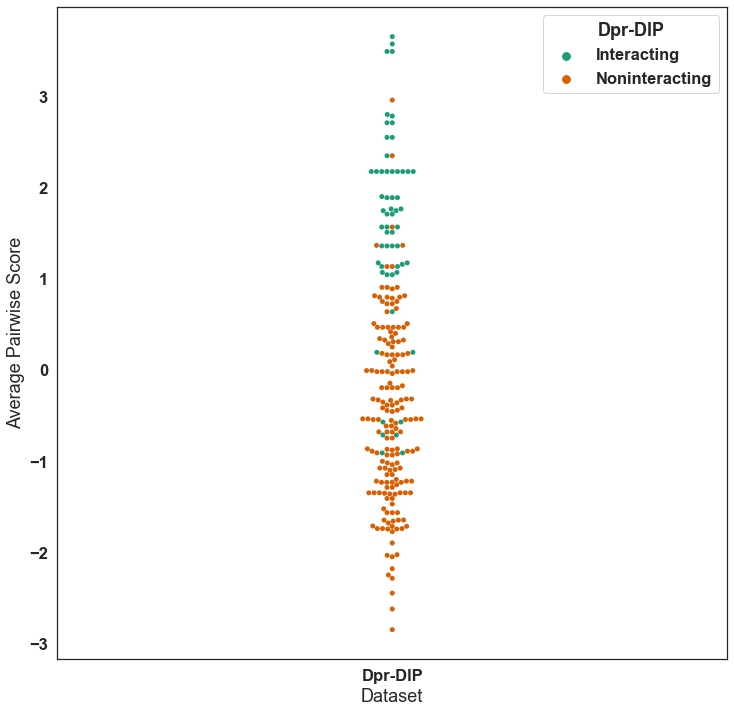

In [26]:
import seaborn as sns
fig = pl.figure(figsize = (12, 12))
dset = ["Dpr-DIP" for x in range(seq1_len+seq2_len)]
reacts = ["Interacting" for x in range(seq1_len)] + ["Noninteracting" for x in range(seq2_len)]
score_all = mda_all
d1 = {'Dataset': dset, 'Average Pairwise Score': score_all.reshape(len(score_all)),
    'Dpr-DIP' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Average Pairwise Score", data=df1, hue = 'Dpr-DIP', palette = "Dark2")

#pl.savefig('MSA_predict.pdf',format='pdf')

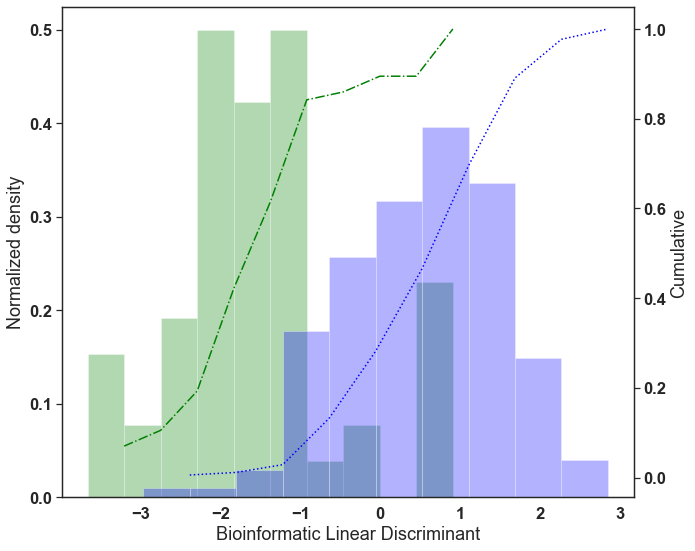

In [29]:
# A nice way to view "distinguishability" of the classifier made by this analysis
data1 = -score_all[:np.shape(seq1)[1]]
data2 = -score_all[np.shape(seq1)[1]:]

fig = pl.figure(figsize = (10, 8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Bioinformatic Linear Discriminant")
ax1.set_ylabel("Normalized density")

ax1.hist(data1, 10, density=True, histtype='bar', color='green', label='interacting', alpha=0.3) 
ax1.hist(data2, 10, density=True, histtype='bar', color='blue', label='non-interacting', alpha=0.3)  

ax2 = ax1.twinx()
H1, X1 = np.histogram(data1, density = True)
dx1 = X1[1] - X1[0]
F1 = np.cumsum(H1)*dx1
pl.plot(X1[1:], F1, color='green', linestyle='-.')

H2, X2 = np.histogram(data2, density = True)
dx2 = X2[1] - X2[0]
F2 = np.cumsum(H2)*dx2
pl.plot(X2[1:], F2, color='blue', linestyle=':')
ax2.set_ylabel("Cumulative")

fig.tight_layout()
#pl.savefig('score_cumul_new.pdf')

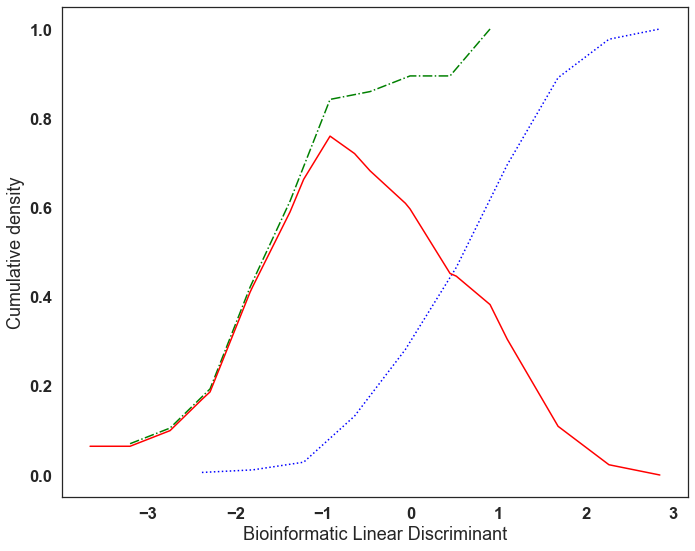

In [30]:
# Then the second plot Benoit wants to see:
fig = pl.figure(figsize = (10,8))
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Bioinformatic Linear Discriminant")
ax1.set_ylabel("Cumulative density")

#--------------Cumulative histogram method
H1, X1 = np.histogram(data1, density = True)
dx1 = X1[1] - X1[0]
F1 = np.cumsum(H1)*dx1
pl.plot(X1[1:], F1, color='green', linestyle='-.', label='interacting')
H2, X2 = np.histogram(data2, density = True)
dx2 = X2[1] - X2[0]
F2 = np.cumsum(H2)*dx2
pl.plot(X2[1:], F2, color='blue', linestyle=':', label='non-interacting')

new_X = np.concatenate([X1, X2])
sorted_X = np.sort(new_X)
interp_F1 = np.interp(sorted_X, X1[1:], F1)
interp_F2 = np.interp(sorted_X, X2[1:], F2)

pl.plot(sorted_X, interp_F1 - interp_F2, color = 'red', label='diff')
fig.tight_layout()
#pl.savefig('MSA_cumuldiff.pdf')

# Viusalize the Weights that Contribute to this Beautiful Distinguishability

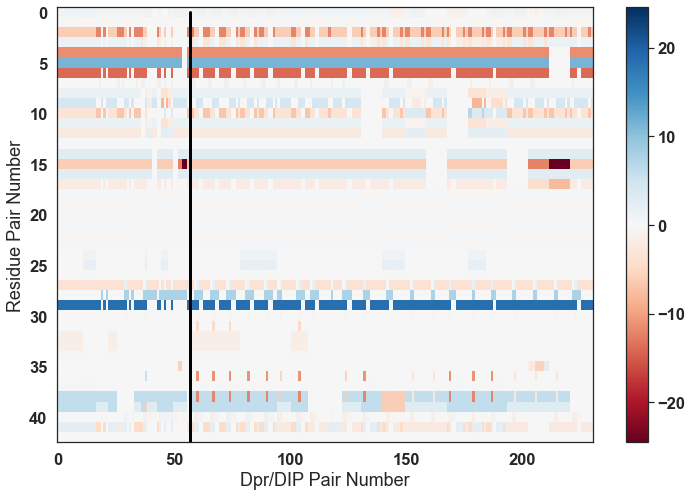

In [31]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(12,8))
weightF = weights

# NOTE: We're taking the abosolute value here so we can see the original contribution
# (ie a productive or detrimental amino acid interaction)
x = pl.imshow(np.transpose(reshape_score*np.abs(weightF)),cmap = 'RdBu',interpolation='nearest', 
              aspect='auto',vmin = -np.max(np.max(reshape_score*weightF)), vmax = np.max(np.max(reshape_score*weightF)))

pl.ylabel('Residue Pair Number')
pl.xlabel('Dpr/DIP Pair Number')
pl.colorbar(x)
pl.plot(seq1_len * np.ones(100),np.linspace(0,np.shape(reshape_score)[1]-0.5,100),'black',linewidth = 3)
#pl.savefig('MSA_weightViz.pdf')

# So in this current version I don't deal with Biophysical Property Clustering
But that would be the logical next step in all of this. For now, however, this code is only included for the purpose of accompanying the Dpr-DIP manuscript. Sometime in the near future this notebook will be expanded upon